# **Dataset context**

The **IBM HR Analytics Employee Attrition & Performance** dataset provides a fictional snapshot of an organization's workforce aimed at helping HR teams and data analysts identify the factors that contribute to employee turnover and performance trends. It features both demographic and job-related variables, enabling the development of predictive models and strategic insights to improve employee retention.

# **Dataset content**
There are 1,470 observations and 35 variables, including:


*   **Age, Gender, MaritalStatus, Education, EducationField** — employee demographics

*   **Department, JobRole, BusinessTravel, OverTime** — job characteristics and work patterns

*   **DistanceFromHome, EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance, RelationshipSatisfaction** — job experience and well‑being

*   **MonthlyIncome, HourlyRate, PercentSalaryHike, StockOptionLevel** — compensation info

*   **TotalWorkingYears, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager, NumCompaniesWorked, TrainingTimesLastYear** — career progression & training metrics
*   **PerformanceRating, JobInvolvement** — performance indicators

*   **DailyRate, MonthlyRate, StandardHours, EmployeeCount, EmployeeNumber, Over18** — various administrative identifiers; some hold constant values and are often dropped during preprocessing

*   **Attrition** — the target variable: whether the employee left (“Yes”/“No”)

*(source: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset)*


In [2]:
%%capture
!pip install streamlit

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.utils import resample
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score, balanced_accuracy_score, accuracy_score, precision_score, f1_score
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics._plot.precision_recall_curve import precision_recall_curve

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTENC, SMOTE

from typing import Dict

from joblib import dump, load
import joblib
import pickle

from dataclasses import field
import streamlit as st

warnings.filterwarnings('ignore')

from google.colab import drive, files
import os

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


# **Load the data**

In [6]:
df = pd.read_csv("/content/drive/MyDrive/WA_Fn-UseC_-HR-Employee-Attrition.csv")

# **EDA**

In [7]:
# Shape of data
df.shape

(1470, 35)

In [8]:
# First 5 rows of data
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [9]:
# Last 5 rows of data
df.tail()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8
1469,34,No,Travel_Rarely,628,Research & Development,8,3,Medical,1,2068,...,1,80,0,6,3,4,4,3,1,2


In [10]:
# Check duplicates - there are no duplicates
len(df[df.duplicated()])

0

In [11]:
# Columns names
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [13]:
# Data types - there are categorical and numerical columns
df.dtypes

,0
Age,int64
Attrition,object
BusinessTravel,object
DailyRate,int64
Department,object
DistanceFromHome,int64
Education,int64
EducationField,object
EmployeeCount,int64
EmployeeNumber,int64


In [15]:
# Unique values in each column
pd.Series({c: df[c].unique() for c in df})

,0
Age,"[41, 49, 37, 33, 27, 32, 59, 30, 38, 36, 35, 2..."
Attrition,"[Yes, No]"
BusinessTravel,"[Travel_Rarely, Travel_Frequently, Non-Travel]"
DailyRate,"[1102, 279, 1373, 1392, 591, 1005, 1324, 1358,..."
Department,"[Sales, Research & Development, Human Resources]"
DistanceFromHome,"[1, 8, 2, 3, 24, 23, 27, 16, 15, 26, 19, 21, 5..."
Education,"[2, 1, 4, 3, 5]"
EducationField,"[Life Sciences, Other, Medical, Marketing, Tec..."
EmployeeCount,[1]
EmployeeNumber,"[1, 2, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16,..."


In [16]:
# Amount of Unique values for each column
df.nunique()

,0
Age,43
Attrition,2
BusinessTravel,3
DailyRate,886
Department,3
DistanceFromHome,29
Education,5
EducationField,6
EmployeeCount,1
EmployeeNumber,1470


In [17]:
# Check missing values - no missing values
df.isna().sum()

,0
Age,0
Attrition,0
BusinessTravel,0
DailyRate,0
Department,0
DistanceFromHome,0
Education,0
EducationField,0
EmployeeCount,0
EmployeeNumber,0


In [18]:
# Data details
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [19]:
# Dataset is completely imbalanced - 1233 employees stayed at company vs 237 left
df['Attrition'].value_counts()

,count
Attrition,
No,1233
Yes,237


In [21]:
# The most employees work for 10 years and the least for 38 years - the data depicted that they are loyal
df['TotalWorkingYears'].value_counts()

,count
TotalWorkingYears,
10,202
6,125
8,103
9,96
5,88
7,81
1,81
4,63
12,48


In [22]:
# The further distance from home, the less employees are in the company from this particular area
df['DistanceFromHome'].value_counts()

,count
DistanceFromHome,
2,211
1,208
10,86
9,85
3,84
7,84
8,80
5,65
4,64


In [23]:
# The most employees work at R&D Department, the least - in HR
df['Department'].value_counts()

,count
Department,
Research & Development,961
Sales,446
Human Resources,63


In [24]:
# Drop columns  - no significant meaning for further analysis
df.drop(columns=['EmployeeCount', 'Over18', 'EmployeeNumber', 'StandardHours'], inplace=True)

In [25]:
# Change the type for columns to categorical
df['Attrition'] = df['Attrition'].astype('category')
df['BusinessTravel'] = df['BusinessTravel'].astype('category')
df['Department'] = df['Department'].astype('category')
df['EducationField'] = df['EducationField'].astype('category')
df['Gender'] = df['Gender'].astype('category')
df['JobRole'] = df['JobRole'].astype('category')
df['MaritalStatus'] = df['MaritalStatus'].astype('category')
df['OverTime'] = df['OverTime'].astype('category')

In [26]:
# Check the details after change - less memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Age                       1470 non-null   int64   
 1   Attrition                 1470 non-null   category
 2   BusinessTravel            1470 non-null   category
 3   DailyRate                 1470 non-null   int64   
 4   Department                1470 non-null   category
 5   DistanceFromHome          1470 non-null   int64   
 6   Education                 1470 non-null   int64   
 7   EducationField            1470 non-null   category
 8   EnvironmentSatisfaction   1470 non-null   int64   
 9   Gender                    1470 non-null   category
 10  HourlyRate                1470 non-null   int64   
 11  JobInvolvement            1470 non-null   int64   
 12  JobLevel                  1470 non-null   int64   
 13  JobRole                   1470 non-null   catego

In [27]:
# Statistics for categorical data
df.describe(include='category').T

,count,unique,top,freq
Attrition,1470,2,No,1233
BusinessTravel,1470,3,Travel_Rarely,1043
Department,1470,3,Research & Development,961
EducationField,1470,6,Life Sciences,606
Gender,1470,2,Male,882
JobRole,1470,9,Sales Executive,326
MaritalStatus,1470,3,Married,673
OverTime,1470,2,No,1054


In [29]:
# Statistics for numerical data - the highest valuesare highlighted in red
df_num_col = df.select_dtypes(exclude=['category']).columns
df_num = df[df_num_col]
df_num.describe().T.style.background_gradient(cmap='Oranges')

,count,mean,std,min,25%,50%,75%,max
Age,1470.000000,36.923810,9.135373,18.000000,30.000000,36.000000,43.000000,60.000000
DailyRate,1470.000000,802.485714,403.509100,102.000000,465.000000,802.000000,1157.000000,1499.000000
DistanceFromHome,1470.000000,9.192517,8.106864,1.000000,2.000000,7.000000,14.000000,29.000000
Education,1470.000000,2.912925,1.024165,1.000000,2.000000,3.000000,4.000000,5.000000
EnvironmentSatisfaction,1470.000000,2.721769,1.093082,1.000000,2.000000,3.000000,4.000000,4.000000
HourlyRate,1470.000000,65.891156,20.329428,30.000000,48.000000,66.000000,83.750000,100.000000
JobInvolvement,1470.000000,2.729932,0.711561,1.000000,2.000000,3.000000,3.000000,4.000000
JobLevel,1470.000000,2.063946,1.106940,1.000000,1.000000,2.000000,3.000000,5.000000
JobSatisfaction,1470.000000,2.728571,1.102846,1.000000,2.000000,3.000000,4.000000,4.000000
MonthlyIncome,1470.000000,6502.931293,4707.956783,1009.000000,2911.000000,4919.000000,8379.000000,19999.000000


In [30]:
# Present cross tabs for all categorical columns separately
df_cat_col = df.select_dtypes(include=['category']).columns

def crosstab_categorical(DataFrame: df) -> None:
  """
    Prints crosstabulations between the target variable 'Attrition' and each categorical feature.

    This function iterates over a predefined list of categorical columns (`df_cat_col`) and
    for each one, prints a crosstab that shows the frequency distribution of 'Attrition' across
    the feature's categories.

    Parameters:
    ----------
    DataFrame : pd.DataFrame
        A pandas DataFrame containing the dataset, including the 'Attrition' column and
        categorical columns listed in `df_cat_col`.

    Returns:
    -------
    None
        This function prints output to the console and does not return a value.
  """
  for i in df_cat_col:
    im = pd.crosstab(index=df['Attrition'], columns=df[i])
    print(im)

crosstab_categorical(df)

Attrition    No  Yes
Attrition           
No         1233    0
Yes           0  237
BusinessTravel  Non-Travel  Travel_Frequently  Travel_Rarely
Attrition                                                   
No                     138                208            887
Yes                     12                 69            156
Department  Human Resources  Research & Development  Sales
Attrition                                                 
No                       51                     828    354
Yes                      12                     133     92
EducationField  Human Resources  Life Sciences  Marketing  Medical  Other  \
Attrition                                                                   
No                           20            517        124      401     71   
Yes                           7             89         35       63     11   

EducationField  Technical Degree  
Attrition                         
No                           100  
Yes                   

In [31]:
df['Attrition'] = df['Attrition'].replace('No', 0).replace('Yes', 1)

print('Stay:', round(df['Attrition'].value_counts()[0] / len(df) * 100, 2), '% of the dataset')
print('Left:', round(df['Attrition'].value_counts()[1] / len(df) * 100, 2), '% of the dataset')

Stay: 83.88 % of the dataset
Left: 16.12 % of the dataset


In [37]:
# Change the type of Attrition column to numerical
df['Attrition'] = df['Attrition'].astype('int64')

# **Visualization**

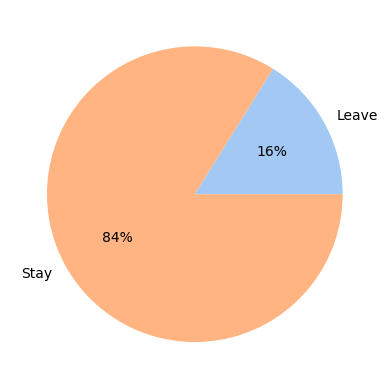

In [38]:
# Based on below countplot for Attrition column, dataset is not well balanced (84% stay vs 16% leave)
left = (df[df['Attrition'] == 1]).count()
stay = (df[df['Attrition'] == 0]).count()
data = [left[0], stay[0]]
colors = sns.color_palette('pastel')
labels = ['Leave', 'Stay']
plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

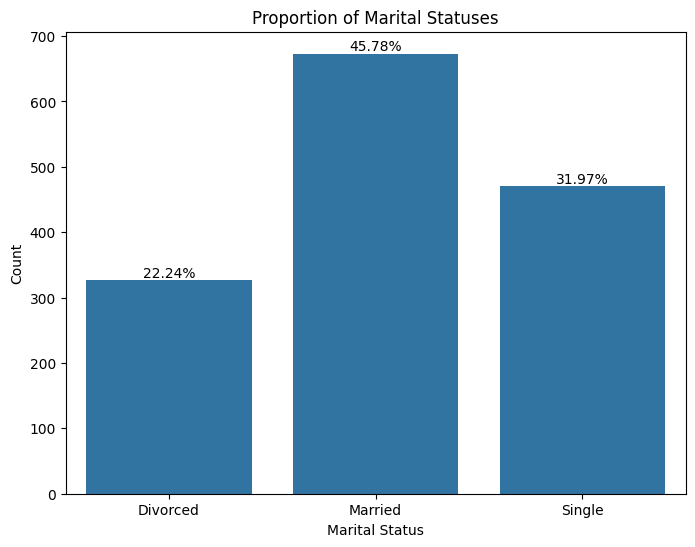

In [39]:
# The most people are married, the least - divorced
marital_status = df['MaritalStatus'].value_counts()

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='MaritalStatus')
plt.title('Proportion of Marital Statuses')
plt.xlabel('Marital Status')
plt.ylabel('Count')

total = len(df['MaritalStatus'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')
plt.show()

<Axes: >

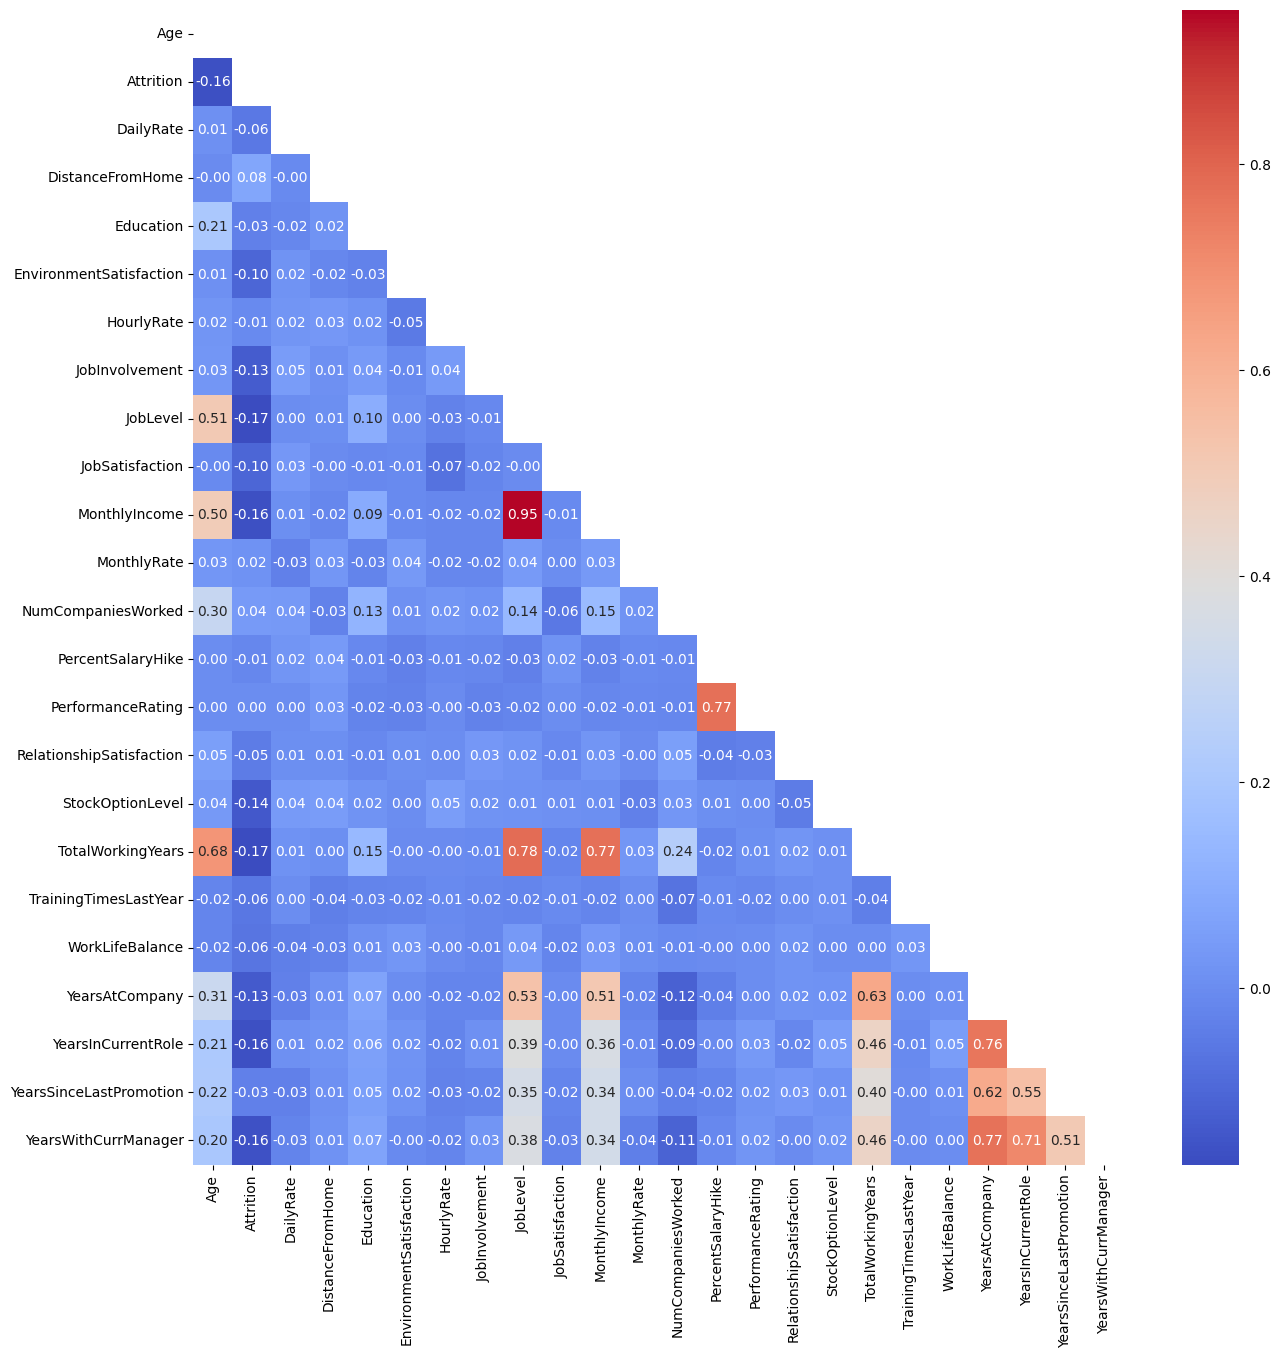

In [40]:
# Plot numeric correlation with heatmap
corr = df.select_dtypes(exclude=['category']).corr()
plt.figure(figsize=(15, 15))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot = True, mask=mask, cmap = 'coolwarm', fmt = ".2f")

## **Remarks for strong correlation**

*   Employees with high job level earn more.
*   Employees with high performance have higher percentage of salary hike.
*   Older workers have more working years in overall.
*   Employees with higher job level have more working years in overall.
*   More experienced employees earn more.
*   There is a strong correlation between years in current role, years at company and years with current manager.

## **Remarks for weak correlation**

*   Hourly rate is not related to environment satisfaction.
*   Number of companies worked does not depend on job satisfaction.
*   Training times last year is not related to number of companies worked.
*   There is weak correlation between number of companies worked and years at company/years in current role/years with current manager.






















# **Outliers detection**

# **Modellling preparation**

In [ ]:
# Retrieving columns which will represent independent/dependent variables
X = df.drop(['Attrition'], axis = 1)
y = df[['Attrition']]

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True, stratify=y, random_state = 111)

In [ ]:
# Feature engineering
num_attr = X_train.select_dtypes(include='number').columns
cat_attr = X_train.select_dtypes(include='category').columns

In [ ]:
# Verify categorical and numerical attributes content
print('Numerical attributes:', num_attr)
print('Categorical attributes:', cat_attr)

Numerical attributes: Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')
Categorical attributes: Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'OverTime'],
      dtype='object')


As mentioned earlier, the dataset is extremely imbalanced.

The common technique of applying SMOTE to the data to over-sample the minority class will be used, without applying any under-sampling.

Next, the fit_resample() function will be run on X_train and y_train data - not on the whole X and y datasets.

The test data needs to reflect how it will appear in the real world, where the classes can not be balanced.

In this case, SMOTENC technique will be used to deal with numerical and categorical features parallelly.

In [ ]:
all_attr = list(num_attr) + list(cat_attr)
# Column transformer to preprocess numeric and categorical columns
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_attr),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_attr)
])

# Function to get pipeline with any model
def get_model_pipeline(model):
    # SMOTENC expects indices of categorical features relative to original input
    categorical_indices = [all_attr.index(col) for col in cat_attr]

    return ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTENC(categorical_features=categorical_indices, random_state=42, k_neighbors=2)),
        ('model', model)
    ])

# **Models**

In [ ]:
param_grid = [
    {
        'model': [LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')],
        'model__C': [0.001, 0.01, 0.1, 1.0, 10, 100],
        'model__penalty': ['l1', 'l2']
    },
    {
        'model': [RandomForestClassifier(random_state=42, class_weight='balanced')],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 5, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    {
        'model': [GradientBoostingClassifier(random_state=42)],
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.8, 1.0]
    },
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2]
    },
    {
        'model': [DecisionTreeClassifier(random_state=42)],
        'model__max_depth': [None, 5, 10, 20],
        'model__criterion': ['gini', 'entropy'],
        'model__min_samples_split': [2, 5, 10]
    },
    {
        'model': [AdaBoostClassifier(random_state=42)],
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.5, 1.0],
        'model__algorithm': ['SAMME', 'SAMME.R']
    }
]

In [ ]:
# Grid Search
grid_search = GridSearchCV(
    estimator=get_model_pipeline(LogisticRegression()),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Evaluation
best_model = grid_search.best_estimator_
print("\nBest Model:", type(best_model.named_steps['model']).__name__)
print("Best Parameters:\n", grid_search.best_params_)

# Train predictions
y_train_pred = best_model.predict(X_train)
print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred))

# Test predictions
y_test_pred = best_model.predict(X_test)
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

Fitting 5 folds for each of 160 candidates, totalling 800 fits

Best Model: GradientBoostingClassifier
Best Parameters:
 {'model': GradientBoostingClassifier(random_state=42), 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 1.0}

Classification Report (Train):
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       863
           1       0.94      0.74      0.83       166

    accuracy                           0.95      1029
   macro avg       0.95      0.87      0.90      1029
weighted avg       0.95      0.95      0.95      1029


Classification Report (Test):
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       370
           1       0.59      0.38      0.46        71

    accuracy                           0.86       441
   macro avg       0.74      0.66      0.69       441
weighted avg       0.84      0.86      0.84       441



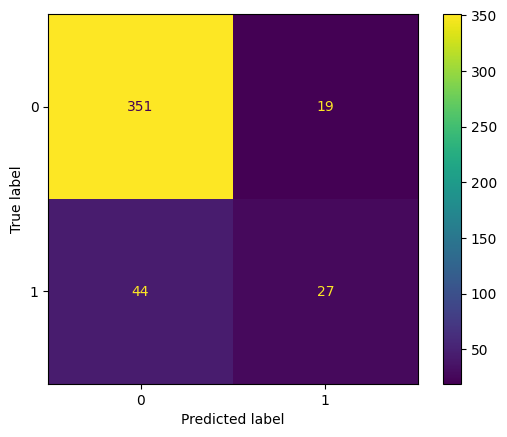

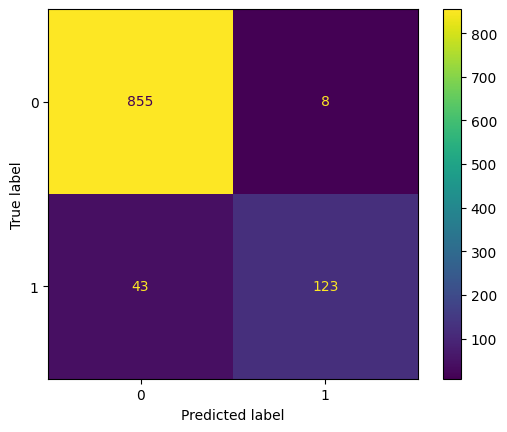

In [ ]:
#Confusion matrix for test set
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
#Confusion matrix for train set
ConfusionMatrixDisplay.from_estimator(best_model, X_train, y_train)

In [ ]:
def get_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float | np.ndarray]:
    """
    Calculates and returns various classification metrics based on true and predicted labels.

    This function computes the following metrics:
      - Accuracy
      - Balanced Accuracy
      - Macro-averaged Recall
      - Macro-averaged Precision
      - Macro-averaged F1 Score
      - F1 Score per class

    Parameters:
    ----------
    y_true : np.ndarray
        Array of true class labels.

    y_pred : np.ndarray
        Array of predicted class labels.

    Returns:
    -------
    dict_metrics : Dict[str, float | np.ndarray]
        A dictionary containing classification metrics with metric names as keys and
        their corresponding values as floats (except for "F1 Scores per Class", which is a NumPy array).
    """
    f1_scores_per_class = f1_score(y_true, y_pred, average=None)

    dict_metrics = {
        'tn, fp, fn, tp': confusion_matrix(y_true, y_pred).ravel(),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Macro Recall': recall_score(y_true, y_pred, average='macro'),
        'Macro Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro F1': f1_score(y_true, y_pred, average='macro'),
        'F1 Scores per Class': f1_scores_per_class
    }
    return dict_metrics

In [ ]:
get_metrics(y_test, y_test_pred)

{'tn, fp, fn, tp': array([351,  19,  44,  27]),
 'Accuracy': 0.8571428571428571,
 'Balanced Accuracy': np.float64(0.6644651693947469),
 'Macro Recall': 0.6644651693947469,
 'Macro Precision': 0.7377820583379197,
 'Macro F1': 0.6895927601809955,
 'F1 Scores per Class': array([0.91764706, 0.46153846])}

In [ ]:
get_metrics(y_train, y_train_pred)

{'tn, fp, fn, tp': array([855,   8,  43, 123]),
 'Accuracy': 0.9504373177842566,
 'Balanced Accuracy': np.float64(0.8658469335045862),
 'Macro Recall': 0.8658469335045862,
 'Macro Precision': 0.9455235553137591,
 'Macro F1': 0.8996610052828111,
 'F1 Scores per Class': array([0.97103918, 0.82828283])}

# **Model deployment**

In [ ]:
with open('/content/best_model_pipeline.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)
# Page config
st.set_page_config(
    page_title="Attrition Prediction",
)

# Page title
st.title('Maintenance - Attrition Prediction')
st.write("\n\n")

# Load the model
with open('/content/best_model_pipeline.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

# Streamlit interface to input data
col1, col2, col3, col4 = st.columns(4)

with col1:
    age = st.number_input(label='Age')
    daily_rate = st.number_input(label='Daily rate')
    distance = st.number_input(label='Distance from home')
    education = st.number_input(label='Education')
    env_sat = st.number_input(label='Environment satisfaction')
    hourly_rate = st.number_input(label='Hourly rate')
    job_inv = st.number_input(label='Job involvment')
    job_level = st.number_input(label='Job level')
    job_sat = st.number_input(label='Job satisfaction')

with col2:
    job_sat = st.number_input(label='Job satisfaction')
    mon_income = st.number_input(label='Monthly income')
    mon_rate = st.number_input(label='Monthly rate')
    num_companies = st.number_input(label='Number of companies worked')
    per_salary = st.number_input(label='Percent salary hike')
    per_rating = st.number_input(label='Performance rating')
    rel_sat = st.number_input(label='Relationship satisfaction')
    st_option = st.number_input(label='Stock option level')

with col3:
    training_times = st.number_input(label='Training times last year')
    working_years = st.number_input(label='Total working years')
    work_life_bal = st.number_input(label='Work-life balance')
    years_at_company = st.number_input(label='Years at company')
    years_role = st.number_input(label='Years in current role')
    years_prom = st.number_input(label='Years since last promotion')
    years_man = st.number_input(label='Years with current manager')

with col4:
    travel = st.selectbox(label='Business travel', options=['Travel_Rarel', 'Travel_Frequently', 'Non-Travel'])
    department = st.selectbox(label='Department', options=['Sales', 'Research & Development', 'Human Resources'])
    field = st.selectbox(label='Education field', options=['Life Sciences', 'Medical', 'Marketing', 'Technical Degree', 'Other', 'Human Resources'])
    gender = st.selectbox(label='Gender', options=['Female', 'Male'])
    role = st.selectbox(label='Job role', options=['Sales Executive','Research Scientist', 'Laboratory Technician', 'Manufacturing Director', 'Healthcare Representative', 'Manager', 'Sales Representative', 'Research Director', 'Human Resources'])
    status = st.selectbox(label='Marital Status', options=['Married', 'Single', 'Divorced'])
    overtime = st.selectbox(label='Overtime', options=['No', 'Yes'])


# Function to predict the input
def prediction():
    # Create a df with input data
    df_input = pd.DataFrame({
        'Age': [age],
        'DailyRate': [daily_rate],
        'DistanceFromHome': [distance],
        'Education': [education],
        'EnvironmentSatisfaction': [env_sat],
        'HourlyRate': [hourly_rate],
        'JobInvolvment': [job_inv],
        'JobLevel': [job_level],
        'JobSatisfaction': [job_sat],
        'MonthlyIncome': [mon_income],
        'MonthlyRate': [mon_rate],
        'NumCompaniesWorked': [num_companies],
        'PercentSalaryHike': [per_salary],
        'PerformanceRating': [per_rating],
        'RelationshipSatisfaction': [rel_sat],
        'StockOptionLevel': [st_option],
        'TotalWorkingYears': [working_years],
        'TrainingTimesLastYear': [training_times],
        'WorkLifeBalance': [work_life_bal],
        'YearsAtCompany': [years_at_company],
        'YearsInCurrentRole': [years_role],
        'YearsSinceLastPromotion': [years_prom],
        'YearsWithCurrManager': [years_man],
        'BusinessTravel': [travel],
        'Department': [department],
        'EducationField': [field],
        'Gender': [gender],
        'JobRole': [role],
        'MaritalStatus': [status],
        'OverTime': [overtime]
    })

    prediction = model.predict(df_input)
    return prediction

# Botton to predict
if st.button('Predict'):
    predict = prediction(age, daily_rate, distance, education, env_sat, hourly_rate, job_inv, job_level, job_sat, mon_income, mon_rate, num_companies, per_salary, per_rating, rel_sat, st_option, working_years, training_times, work_life_bal, years_at_company, years_role, years_prom, years_man, travel, department, field, gender, role, statu
)
    st.success(predict)